In [1]:
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import utils
import datasets_local
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

utils.set_seeds(1013)


N_LAYERS = {
    'lealla-large': 24,
}
EMB_DIM = {
    'lealla-large': 256,
}

MIN_LR = 1e-6
MAX_LR = 5e-5
BATCH_SIZE = 96
BATCH_SIZE = 128

START_LAYER = 0
END_LAYER = 25

MAX_ITERS = 500
N_WARMUP_STEPS = 50
EVAL_FREQ = 25

model_name = "setu4993/LEALLA-large"
model_path_name = model_name.lower().split('/')[-1]

device = torch.device('cuda')
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

src_lang = 'deu-esp-eng'
lang_counts = [2603, 1996, 2768]
psums = np.cumsum(lang_counts)

mtd_path = f'./data/track_a/train/{src_lang}.csv'
mtd = pd.read_csv(mtd_path)
targets = [c for c in mtd.columns if c not in ['id', 'text']]
all_labels = mtd[targets].to_numpy().astype(np.float32)

train_indices, val_indices = utils.load_split_indices(model_name, src_lang)
train_ds = datasets_local.CBDatasestMTB(
    data = mtd.text.to_numpy()[train_indices],
    task_labels = all_labels[train_indices],
    batch_size=BATCH_SIZE,
)
val_ds = datasets_local.EmbeddingsDataset(
    mtd.text.to_numpy()[val_indices],
    all_labels[val_indices]
)

ID_LANGS = ['deu', 'esp', 'eng']
OOD_LANGS = ['ron', 'ukr', 'hin']
all_predictions_dir = './predictions/finetune/'

lang_mtds = {
    lang: None for lang in OOD_LANGS
}
lang_targets = {
    lang: None for lang in OOD_LANGS
}
lang_dataloaders = {
    lang: None for lang in OOD_LANGS
}

for lang in OOD_LANGS:
    mtd = pd.read_csv(f'./data/track_c/dev/{lang}.csv')
    lang_mtds[lang] = mtd

    targets_ = [c for c in mtd.columns if c not in ['id', 'text']]
    for c in targets_:
        if c not in targets: # can't make predictions for this emotion; place zeros
            mtd[c] = [0 for _ in range(len(mtd))]
    lang_targets[lang] = targets_


    ds = datasets_local.EmbeddingsDataset(mtd.text.to_list(), np.zeros(len(mtd), dtype=np.float32))
    lang_dataloaders[lang] = DataLoader(ds, batch_size=512, shuffle=False, num_workers=0)

    mtd.drop(columns=['text'], inplace=True) # remove texts to prep mtd for predictions

for lang in ID_LANGS:
    mtd = pd.read_csv(f'./data/track_a/dev/{lang}.csv')
    lang_mtds[lang] = mtd

    targets_ = [c for c in mtd.columns if c not in ['id', 'text']]
    for c in targets_:
        if c not in targets: # can't make predictions for this emotion; place zeros
            mtd[c] = [0 for _ in range(len(mtd))]
    lang_targets[lang] = targets_


    ds = datasets_local.EmbeddingsDataset(mtd.text.to_list(), np.zeros(len(mtd), dtype=np.float32))
    lang_dataloaders[lang] = DataLoader(ds, batch_size=512, shuffle=False, num_workers=0)

    mtd.drop(columns=['text'], inplace=True) # remove texts to prep mtd for predictions


In [2]:
def pooler_output_getter(out):
    return out['pooler_output']

def cls_token_output_getter(out):
    return out['last_hidden_state'][:, 0, :]

class Classifier(nn.Module):
    def __init__(self, backbone, backbone_emb_getter, emb_dim, n_classes):
        super().__init__()
        self.backbone = backbone
        self.backbone_embedding_getter = backbone_emb_getter
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.cls_layer = nn.Linear(emb_dim, n_classes, bias=True)
    
    def forward(self, **x):
        out = self.backbone(**x)
        embeddings = self.backbone_embedding_getter(out)
        return self.cls_layer(embeddings)
    
classifier = Classifier(model, pooler_output_getter, emb_dim=EMB_DIM[model_path_name], n_classes=all_labels.shape[1])
# initi cls layer
with torch.no_grad(): 
    for i, target in enumerate(targets):
        st_path = f'./classifiers/{src_lang}/emb/model_{target}.pt'
        st = torch.load(st_path, map_location='cpu')
        classifier.cls_layer.weight.data[i].copy_(st['weight'].squeeze())
        classifier.cls_layer.bias.data[i].copy_(st['bias'].squeeze())

model.requires_grad_(False)
trainable_params = [model.encoder.layer[:-4], model.pooler]
for p in trainable_params:
    p.requires_grad_(True)

optimizer = torch.optim.AdamW([p for p in classifier.parameters() if p.requires_grad], lr=1e-4, weight_decay=1e-4)

def collate_fn(batch):
    return batch[0][0], torch.tensor(batch[0][1])

train_dl = DataLoader(train_ds, batch_size=1, collate_fn=collate_fn)
train_iter = iter(train_dl)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
loss_fn = nn.BCEWithLogitsLoss(reduction='none')

/tmp/ipykernel_3599/4112512645.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load(st_path, map_location='cpu')


100%|██████████| 2000/2000 [15:22<00:00,  2.17it/s]


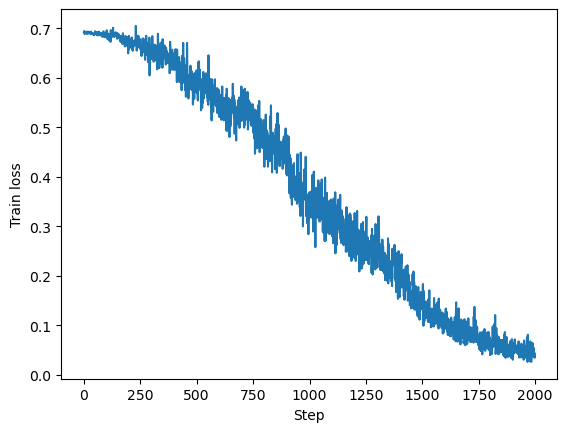

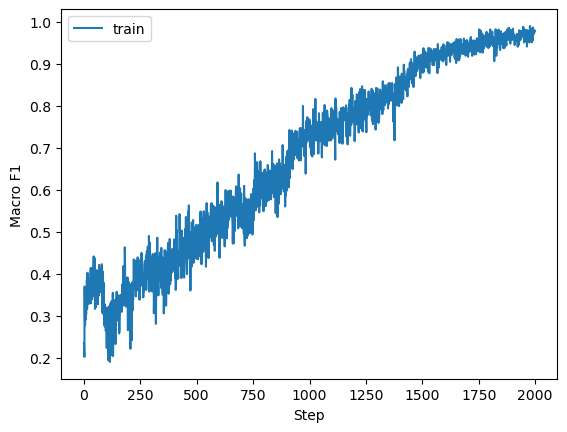

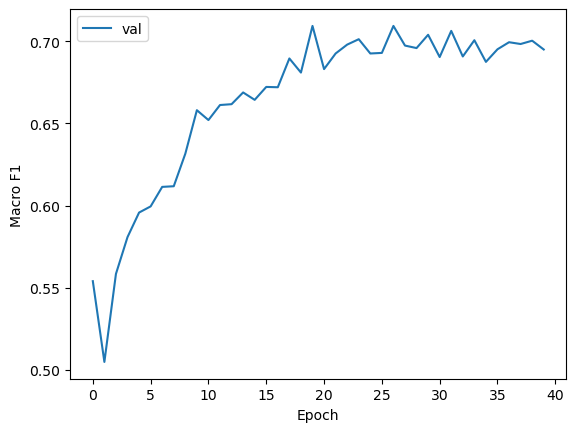

In [3]:
MAX_ITERS = 2001
N_WARMUP_STEPS = 50
EVAL_FREQ = 50
PREDICTIONS_FREQ = 250

classifier.eval()
classifier.to(device)
for x in trainable_params:
    x.train()
classifier.cls_layer.train()

train_f1s = []
all_f1s = []
val_f1s = []
all_val_f1s = []
all_losses = []

best_val_f1 = 0
checkpoint_dir = f'./finetunes/{model_path_name}/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = checkpoint_dir + 'model.pt'

per_lang_f1s = {i: [] for i in range(3)}
per_lang_all_f1s = {i: [] for i in range(3)}


grads = []

for step in tqdm(range(1, MAX_ITERS)):
    batch_texts, batch_labels = next(train_iter)
    batch_labels = batch_labels.to(device)
    outputs = classifier(**tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True).to(device))
    
    predictions_ = []
    labels_ = []
    lss = []
    loss = 0
    for target_idx in range(classifier.n_classes):
        mask = batch_labels[:, target_idx] > -0.5 ## remove samples for which we don't have labels
        blabels_ = batch_labels[mask, target_idx]
        bouts_ = outputs[mask, target_idx]
        losses = loss_fn(bouts_, blabels_)
        losses = [torch.mean(losses[blabels_ == 0]), torch.mean(losses[blabels_ == 1])] # loss per class
        loss += sum(losses) / 2
        lss.append((sum(losses) / 2).item())

        preds_ = utils.get_predictions_bce(bouts_)
        predictions_.append(preds_.cpu().numpy())
        labels_.append(blabels_.cpu().numpy())
    
    # det_losses.append(lss)
    loss /= classifier.n_classes
    loss.backward()
    grads.append(torch.nn.utils.clip_grad_norm_(optimizer.param_groups[0]['params'], max_norm=3, norm_type=2).detach().cpu().numpy().item())

    optimizer.step()

    optimizer.zero_grad()
    all_losses.append(loss.item())
    loss = None

    f1s = [f1_score(l, p) for l,p in zip(labels_, predictions_)]
    all_f1s.append(f1s)
    train_f1s.append(np.mean(f1s))

    
    if step % EVAL_FREQ == 0:
        predictions_ = []
        labels_ = []
        classifier.eval()
        with torch.no_grad():

            for batch_texts, batch_labels in val_dl:
                outputs = classifier(**tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True).to(device))
                preds_ = utils.get_predictions_bce(outputs)
                predictions_.append(preds_.cpu().numpy())
                labels_.append(batch_labels.cpu().numpy())
        
        predictions_ = np.concatenate(predictions_, axis=0)
        labels_ = np.concatenate(labels_, axis=0)
        
        val_f1s_ = []
        for target_idx in range(classifier.n_classes):
            mask = labels_[:, target_idx] > -0.5 ## remove samples for which we don't have labels
            bpreds = predictions_[mask, target_idx]
            blabels_ = labels_[mask, target_idx]
            val_f1s_.append(f1_score(blabels_, bpreds))

        val_f1s.append(np.mean(val_f1s_))
        all_val_f1s.append(val_f1s_)
        if val_f1s[-1] >= best_val_f1:
            torch.save(classifier.cpu().state_dict(), checkpoint_path)
            best_val_f1 = val_f1s[-1]
        classifier.to(device)
        
        prev_idx = 0
        for lang_nr in range(3):
            mask = (prev_idx <= val_indices) & (val_indices < psums[lang_nr])
            val_f1s_ = []
            for target_idx in range(classifier.n_classes):
                mask = labels_[:, target_idx] > -0.5 ## remove samples for which we don't have labels
                bpreds = predictions_[mask, target_idx]
                blabels_ = labels_[mask, target_idx]
                val_f1s_.append(f1_score(blabels_, bpreds))

            per_lang_f1s[lang_nr].append(np.mean(val_f1s_))
            per_lang_all_f1s[lang_nr].append(val_f1s_)
            prev_idx = psums[lang_nr]

        if step % PREDICTIONS_FREQ == 0:
            step_pred_dir = all_predictions_dir + f'{int(step / EVAL_FREQ)}/'
            os.makedirs(step_pred_dir, exist_ok=True)
            for lang in OOD_LANGS:
                predictions_ = []
                with torch.no_grad():
                    for batch_texts, _ in lang_dataloaders[lang]:
                        outputs = classifier(**tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True).to(device))
                        preds_ = utils.get_predictions_bce(outputs)
                        predictions_.append(preds_.cpu().numpy())
                predictions_ = np.concatenate(predictions_, axis=0)

                for i, c in enumerate(targets): 
                    if c in lang_targets[lang]: 
                        lang_mtds[lang][c] = predictions_[:, i] # place emotion predictions in the lang mtd
                
                lang_mtds[lang].to_csv(step_pred_dir + f'pred_{lang}.csv', index=False) # save predictions at current step
            
            plt.plot(val_f1s, label='val')
            plt.xlabel('Epoch')
            plt.ylabel('Macro F1')
            plt.legend()
            plt.savefig(checkpoint_dir + 'val_f1s.png')
            plt.close() ## also save intermediate plot 
        
        for x in trainable_params:
            x.train()
        classifier.cls_layer.train()
        classifier.to(device)


np.save(checkpoint_dir + 'targets.npy', targets, allow_pickle=True)
np.save(checkpoint_dir + 'train_f1s.npy', train_f1s, allow_pickle=True)
np.save(checkpoint_dir + 'all_train_f1s.npy', all_f1s, allow_pickle=True)
np.save(checkpoint_dir + 'val_f1s.npy', val_f1s, allow_pickle=True)
np.save(checkpoint_dir + 'all_val_f1s.npy', all_val_f1s, allow_pickle=True)
np.save(checkpoint_dir + 'per_lang_f1s.npy', per_lang_f1s, allow_pickle=True)
np.save(checkpoint_dir + 'per_lang_all_f1s.npy', per_lang_all_f1s, allow_pickle=True)

plt.plot(all_losses)
plt.xlabel('Step')
plt.ylabel('Train loss')
plt.show()

plt.plot(train_f1s, label='train')
plt.xlabel('Step')
plt.ylabel('Macro F1')
plt.legend()
plt.show()

plt.plot(val_f1s, label='val')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.savefig(checkpoint_dir + 'val_f1s.png')
plt.show()

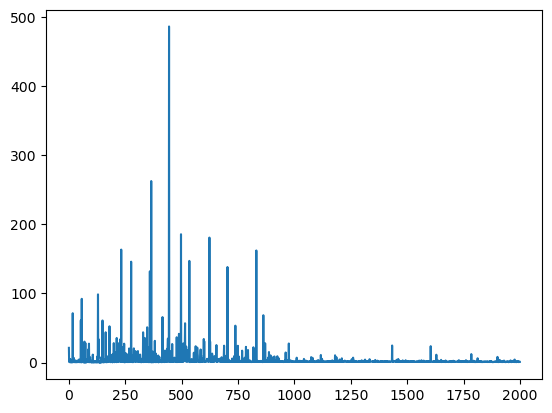

In [4]:
plt.plot(grads)
plt.show()

In [5]:
# make predictions on best checkpoint
checkpoint_dir = f'./finetunes/{model_path_name}/'
checkpoint_path = checkpoint_dir + 'model.pt'

classifier.load_state_dict(torch.load(checkpoint_path))
classifier.to(device)
classifier.eval()
classifier.requires_grad_(False)

pred_dir = all_predictions_dir + f'val_best/'
os.makedirs(pred_dir, exist_ok=True)

for lang in OOD_LANGS:
    predictions_ = []
    with torch.no_grad():
        for batch_texts, _ in lang_dataloaders[lang]:
            outputs = classifier(**tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True).to(device))
            preds_ = utils.get_predictions_bce(outputs)
            predictions_.append(preds_.cpu().numpy())
    predictions_ = np.concatenate(predictions_, axis=0)

    for i, c in enumerate(targets): 
        if c in lang_targets[lang]: 
            lang_mtds[lang][c] = predictions_[:, i] # place emotion predictions in the lang mtd
    
    lang_mtds[lang].to_csv(pred_dir + f'pred_{lang}.csv', index=False) # save predictions at current step


/tmp/ipykernel_11738/1227790270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(checkpoint_path))


In [5]:
## id individual predictions for task a
checkpoint_dir = f'./finetunes/{model_path_name}/'
checkpoint_path = checkpoint_dir + 'model.pt'

classifier.load_state_dict(torch.load(checkpoint_path))
classifier.to(device)
classifier.eval()
classifier.requires_grad_(False)

pred_dir = all_predictions_dir + f'id/'
os.makedirs(pred_dir, exist_ok=True)

for lang in ID_LANGS:
    predictions_ = []
    with torch.no_grad():
        for batch_texts, _ in lang_dataloaders[lang]:
            outputs = classifier(**tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True).to(device))
            preds_ = utils.get_predictions_bce(outputs)
            predictions_.append(preds_.cpu().numpy())
    predictions_ = np.concatenate(predictions_, axis=0)

    for i, c in enumerate(targets): 
        if c in lang_targets[lang]: 
            lang_mtds[lang][c] = predictions_[:, i] # place emotion predictions in the lang mtd
    
    lang_mtds[lang].to_csv(pred_dir + f'pred_{lang}.csv', index=False) # save predictions at current step



/tmp/ipykernel_3599/3878078067.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(checkpoint_path))


In [ ]:
## logistic regression intead of linear probe
## large models; Qwen/Llama 3.2

In [36]:
embs = np.load('./embeddings/lealla-large/deu-esp-eng/train.npy')
mtd = pd.read_csv('./data/track_a/train/deu-esp-eng.csv')
labels = mtd['anger'].to_numpy()

In [37]:
from sklearn.decomposition import PCA
pca = PCA(2)
ld = pca.fit_transform(embs)

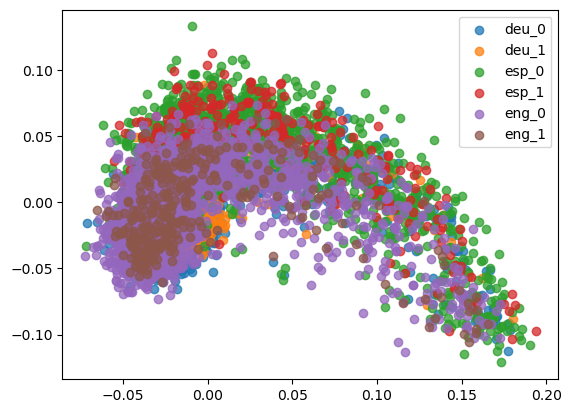

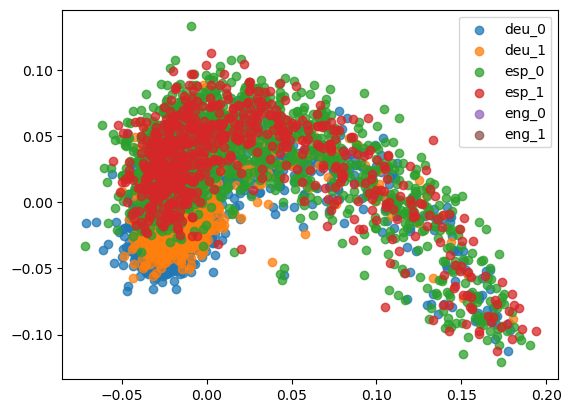

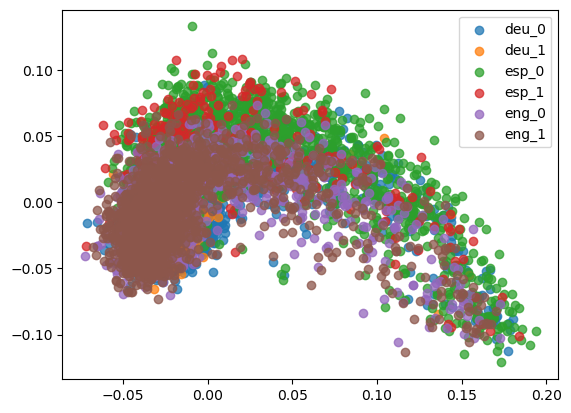

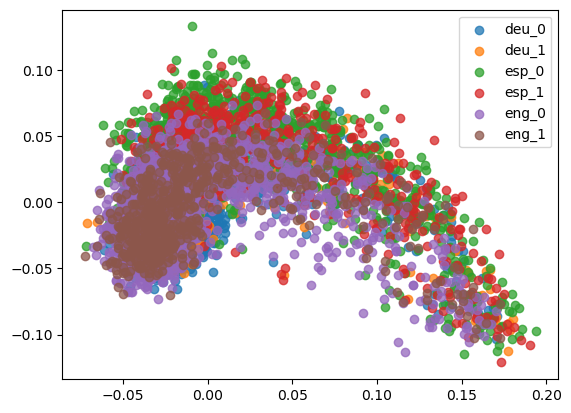

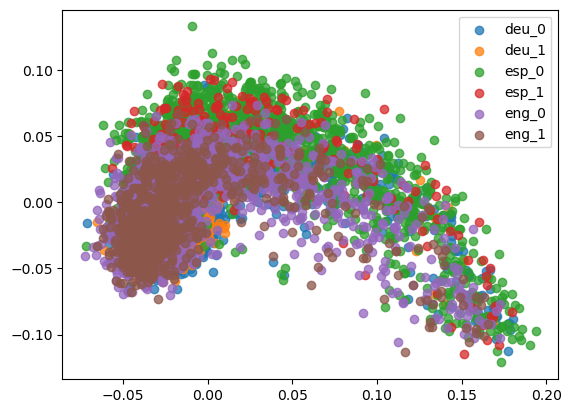

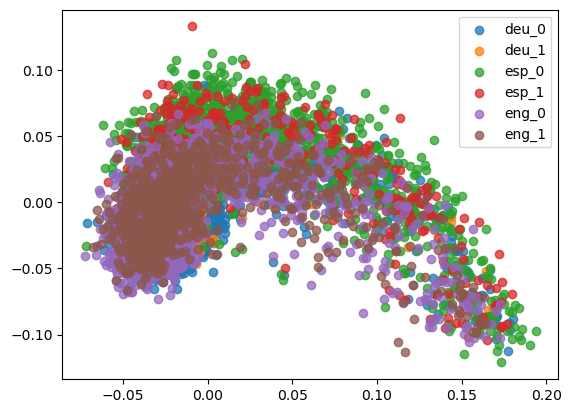

In [40]:
for c in mtd.columns[2:]:
    labels = mtd[c].to_numpy()
    plt.scatter(ld[:2603, 0][labels[:2603] == 0], ld[:2603, 1][labels[:2603]==0], label='deu_0', alpha=0.75)
    plt.scatter(ld[:2603, 0][labels[:2603] == 1], ld[:2603, 1][labels[:2603]==1], label='deu_1', alpha=0.75)
    plt.scatter(ld[2603:4599, 0][labels[2603:4599] == 0], ld[2603:4599, 1][labels[2603:4599]==0], label='esp_0', alpha=0.75)
    plt.scatter(ld[2603:4599, 0][labels[2603:4599] == 1], ld[2603:4599, 1][labels[2603:4599]==1], label='esp_1', alpha=0.75)
    plt.scatter(ld[4599:, 0][labels[4599:] == 0], ld[4599:, 1][labels[4599:]==0], label='eng_0', alpha=0.75)
    plt.scatter(ld[4599:, 0][labels[4599:] == 1], ld[4599:, 1][labels[4599:]==1], label='eng_1', alpha=0.75)
    plt.legend()
    plt.show()

In [ ]:
## plot for ro per language
# plot embeddings in 2d across layers# # pca/tsne/umap

## lang specific encoder for better results
